<img src="https://geodecode.com.br/wp-content/uploads/2021/12/brasildatacube.png" align="left" width="74"/>
<img src="https://brazil-data-cube.github.io/_images/logo-odc-bdc.png" align="right" width="74" />

<h1 style="color:#336699; text-align: center" >Annual Metting Use Case</h1>
<hr style="border:2px solid #0077b9;">

<br/>

<div style="text-align: center;font-size: 90%;">
    <sup>
        <a href="https://orcid.org/0000-0002-9916-1167">
            <i class="fab fa-lg fa-orcid" style="color: #a6ce39"></i>
        </a>
    </sup>
    <br/>
    Brazil Data Cube (BDC), National Institute for Space Research (INPE)
    <br/>
    <br/>
    <br/>
    <div style="width: 98%;">
        <div style="text-align: justify; border-style: solid; border-color: #0077b9; border-width: 1px; padding: 10px;">
            <b>Explantion here....:</b>
            <div>
                Write write write write writewrite writewrite write. <a href="http://www.brazildatacube.org/" target="_blank">Site site site site site</a>, <i> Outras infos</i> .......
            </div>
        </div>
    </div>
</div>

In [1]:
# # library(geojsonsf)
# # library(sfheaders)
# library(jsonlite)
# library(httr)
# library(raster)
# library(rstac)
# library(gdalcubes)
# library(tmap)
# library(ggplot2)
library(dplyr)
library(sf)
library(sits)
library(stringr)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Linking to GEOS 3.10.2, GDAL 3.4.1, PROJ 8.2.1; sf_use_s2() is TRUE

SITS - satellite image time series analysis.

Loaded sits v1.4.2-1.
        See ?sits for help, citation("sits") for use in publication.
        Documentation avaliable in https://e-sensing.github.io/sitsbook/.



# Set constants and ROI
<hr style="border:1px solid #0077b9;">

### If BDC-Lab, set config.yaml

In [6]:
# Set config if using BDC Lab
sits_config(config_user_file = "config.yaml")

### Set constants

In [2]:
# MULTICORES <- 3L
MULTICORES <- 2L

START_DATE <- "2019-01-01"
# END_DATE <- "2021-12-31"
END_DATE <- "2019-12-31"

### Get ROI and BBOX

In [3]:
shape_sf <- st_read("roi/mun_indireto_PA.shp")
shape_df <- data.frame(shape_sf)

dim(shape_df)
head(shape_df)

bbox <- st_bbox(shape_sf)
bbox

Reading layer `mun_indireto_PA' from data source 
  `/home/luana/git/harmonize/annual_meeting_use_case/roi/mun_indireto_PA.shp' 
  using driver `ESRI Shapefile'
Simple feature collection with 21 features and 5 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -50.9967 ymin: -5.196937 xmax: -48.13749 ymax: -1.019427
Geodetic CRS:  SIRGAS 2000


[1] 21  6

,CD_MUN,NM_MUN,SIGLA,AREA_KM2,cod,geometry
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<POLYGON [°]>
1,1500107,Abaetetuba,PA,1610.654,NA,POLYGON ((-48.83139 -1.5635...
2,1500800,Ananindeua,PA,190.581,NA,POLYGON ((-48.33466 -1.2398...
3,1501105,Bagre,PA,4397.321,NA,POLYGON ((-50.29255 -1.8063...
4,1501204,Baião,PA,3759.834,NA,POLYGON ((-49.48643 -2.6631...
5,1501303,Barcarena,PA,1310.338,NA,POLYGON ((-48.4695 -1.59545...
6,1501402,Belém,PA,1059.466,NA,POLYGON ((-48.35304 -1.2210...


      xmin       ymin       xmax       ymax 
-50.996702  -5.196937 -48.137491  -1.019427 

# List SITS collections
<hr style="border:1px solid #0077b9;">

In [6]:
sits_list_collections()

BDC:
- CBERS-WFI-16D (CBERS-4/WFI)
- grid system: BDC-Large V2
- bands: NDVI EVI B13 B14 B15 B16 CLOUD
- opendata collection (requires access token)

- CBERS-WFI-8D (CBERS-4-4A/WFI)
- grid system: BDC-Large V2
- bands: NDVI EVI B13 B14 B15 B16 CLOUD
- opendata collection (requires access token)

- CBERS-MUX-2M (CBERS-4/MUX)
- grid system: BDC-Medium V2
- bands: NDVI EVI B05 B06 B07 B08 CLOUD
- opendata collection (requires access token)

- LANDSAT-OLI-16D (LANDSAT-8/OLI)
- grid system: BDC-Medium V1
- bands: NDVI EVI COASTAL BLUE GREEN RED NIR08 SWIR16 SWIR22 CLOUD
- opendata collection (requires access token)

- LANDSAT-2M (LANDSAT/TM-ETM-OLI)
- grid system: BDC-Medium V2
- bands: COASTAL BLUE GREEN RED NIR08 SWIR16 SWIR22 NDVI EVI CLOUD
- opendata collection (requires access token)

- MOD13Q1-6 (TERRA/MODIS)
- grid system: STG
- bands: NDVI EVI BLUE RED NIR MIR CLOUD
- opendata collection (requires access token)

- MYD13Q1-6 (AQUA/MODIS)
- grid system: STG
- bands: NDVI EVI BLUE RED 

# Compute NDVI mean for each municipality
<hr style="border:1px solid #0077b9;">

<!-- ![Figure 2](https://raw.githubusercontent.com/e-sensing/sitsbook/master/images/data_cube_generation.png) -->

### 1.1 Create output folders

In [4]:
# Folders names
ORIGINAL_IMAGES_FOLDER <- "original_tifs"
MONTHLY_IMAGES_FOLDER <- "monthly_aggr_by_tile"
MOSAIC_IMAGES_FOLDER <- "mosaic_by_month"
MOSAIC_CSVS_IMAGES_FOLDER <- "mosaic_by_month_csvs"

# Create folders if not created
folders_to_create <- c(ORIGINAL_IMAGES_FOLDER, MONTHLY_IMAGES_FOLDER, MOSAIC_IMAGES_FOLDER, MOSAIC_CSVS_IMAGES_FOLDER)
for (folder_name in folders_to_create){
  if (!file.exists(folder_name)) {
    dir.create(folder_name, recursive = TRUE)
    print(paste0(folder_name, " folder created successfully."))
  }
  else{
    print(paste0("Folder ", folder_name, " already exists!"))
  }
}

[1] "Folder original_tifs already exists!"
[1] "Folder montly_aggr_by_tile already exists!"
[1] "Folder mosaic_by_month already exists!"
[1] "Folder mosaic_by_month_csvs already exists!"


### 1.2 Set collection id

In [5]:
COLLECTION_ID <- "SENTINEL-2-16D"

### 1.3 Search images using sits_cube (get metadata)
- Using 2 CPUs, 3 years, it took 1 min to get metadata

Warning message:
“object has no crs, assuming 'EPSG:4326'”


  |======================================================================| 100%
  |======================================================================| 100%
[1] "Execution time: 58.4314918518066 seconds"


[1] "2019-01-01" "2019-01-17" "2019-02-02" "2019-02-18" "2019-03-06"
 [6] "2019-03-22" "2019-04-07" "2019-04-23" "2019-05-09" "2019-05-25"
[11] "2019-06-10" "2019-06-26" "2019-07-12" "2019-07-28" "2019-08-13"
[16] "2019-08-29" "2019-09-14" "2019-09-30" "2019-10-16" "2019-11-01"
[21] "2019-11-17" "2019-12-03" "2019-12-19"

# A tibble: 46 × 14
   fid      date       band   xres  yres   xmin   ymin   xmax   ymax nrows ncols
   <chr>    <date>     <chr> <dbl> <dbl>  <dbl>  <dbl>  <dbl>  <dbl> <dbl> <dbl>
 1 S2-16D_… 2019-01-01 CLOUD    10    10 5.26e6 1.12e7 5.37e6 1.13e7 10560 10560
 2 S2-16D_… 2019-01-01 NDVI     10    10 5.26e6 1.12e7 5.37e6 1.13e7 10560 10560
 3 S2-16D_… 2019-01-17 CLOUD    10    10 5.26e6 1.12e7 5.37e6 1.13e7 10560 10560
 4 S2-16D_… 2019-01-17 NDVI     10    10 5.26e6 1.12e7 5.37e6 1.13e7 10560 10560
 5 S2-16D_… 2019-02-02 CLOUD    10    10 5.26e6 1.12e7 5.37e6 1.13e7 10560 10560
 6 S2-16D_… 2019-02-02 NDVI     10    10 5.26e6 1.12e7 5.37e6 1.13e7 10560 10560
 7 S2-16D_… 2019-02-18 CLOUD    10    10 5.26e6 1.12e7 5.37e6 1.13e7 10560 10560
 8 S2-16D_… 2019-02-18 NDVI     10    10 5.26e6 1.12e7 5.37e6 1.13e7 10560 10560
 9 S2-16D_… 2019-03-06 CLOUD    10    10 5.26e6 1.12e7 5.37e6 1.13e7 10560 10560
10 S2-16D_… 2019-03-06 NDVI     10    10 5.26e6 1.12e7 5.37e6 1.13e7 10560 10560
# ℹ 36 m

plotting false color image



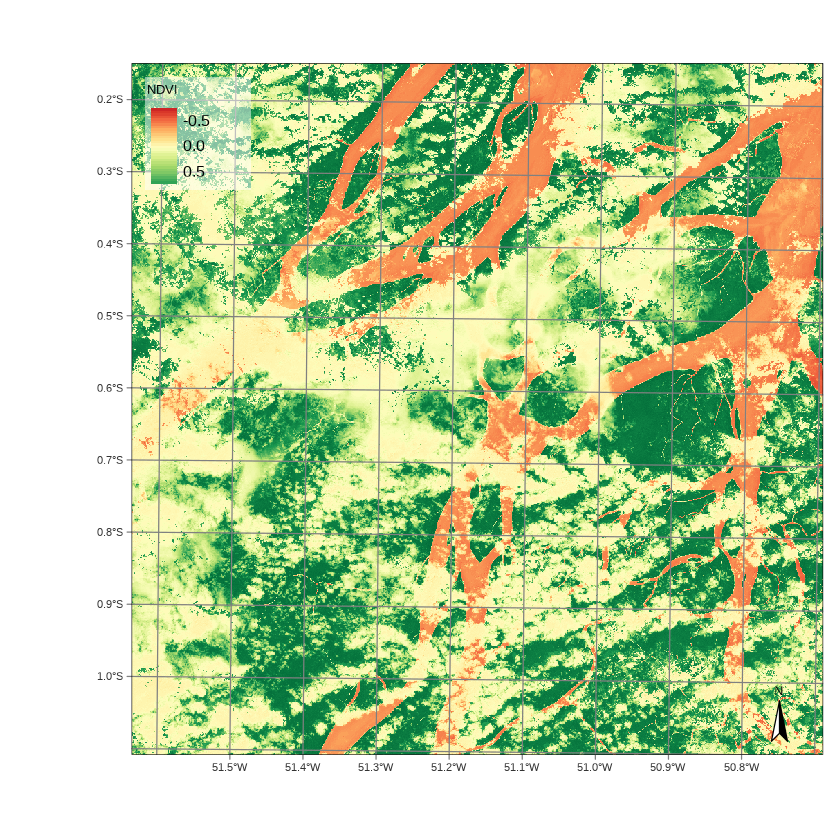

In [6]:
# Obtain metadata
st <- Sys.time()
s2_cube <- sits_cube(
  source = "BDC",
  collection = COLLECTION_ID,
  bands = c("NDVI", "CLOUD"),
  roi = bbox,
  start_date = START_DATE,
  end_date = END_DATE,
  progress = TRUE
)
proc_time_s <- difftime(Sys.time(), st, units = "secs")
print(paste0("Execution time: ", proc_time_s, " seconds"))

sits_timeline(s2_cube)
print(s2_cube$file_info[[1]])
plot(s2_cube, band = "NDVI", time = 1)

# sits_to_csv(s2_cube, file = csv_file)

### 1.4 (If not using BDC-Lab) Download all images loccaly
- For 3 years, bands "NDVI","CLOUD", approximately 350 GB

In [7]:
st <- Sys.time()
cube_local <- sits_cube_copy(
  cube = s2_cube,
  output_dir = ORIGINAL_IMAGES_FOLDER,
  multicores = MULTICORES
)
proc_time_s <- difftime(Sys.time(), st, units = "secs")
print(paste0("Execution time: ", proc_time_s, " seconds"))

head(t(cube_local))

  |=                                                                     |   1%

### 1.5 Aggregate all tiles of same month in one
- Using 60 cores, it took 2.4 min to aggregate 288 images in 72 (tile/month)
- Using 2 cores, it took XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX min to aggregate 288 images in 72 (tile/month)
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXx
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXx
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXx
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXx
- 2700s to aggregate....
- 518s to aggregate 250m 1M

Warning message:
“Regularization works better when data store locally. Please, use 'sits_cube_copy()' to copy data locally before regularization”


  |======================================================================| 100%
  |======================================================================| 100%
[1] "Execution time: 2685.09147977829 seconds"


[1] "2019-01-01" "2019-02-01" "2019-03-01" "2019-04-01" "2019-05-01"
 [6] "2019-06-01" "2019-07-01" "2019-08-01" "2019-09-01" "2019-10-01"
[11] "2019-11-01" "2019-12-01" "2020-01-01" "2020-02-01" "2020-03-01"
[16] "2020-04-01" "2020-05-01" "2020-06-01" "2020-07-01" "2020-08-01"
[21] "2020-09-01" "2020-10-01" "2020-11-01" "2020-12-01" "2021-01-01"
[26] "2021-02-01" "2021-03-01" "2021-04-01" "2021-05-01" "2021-06-01"
[31] "2021-07-01" "2021-08-01" "2021-09-01" "2021-10-01" "2021-11-01"
[36] "2021-12-01"

plotting false color image



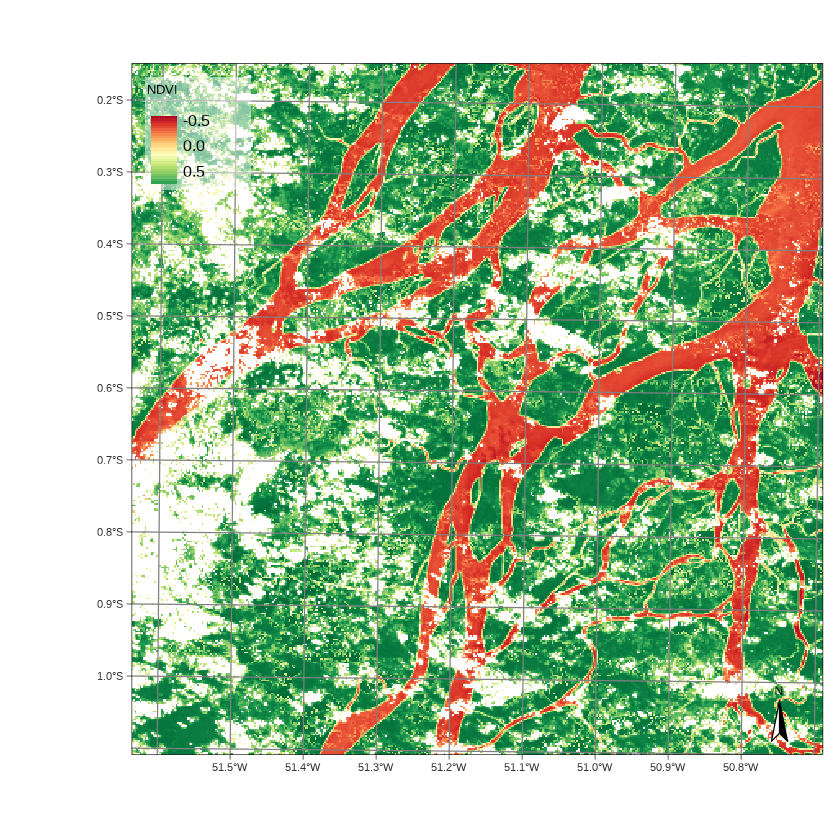

In [14]:
# cube_local <- s2_cube

st <- Sys.time()
s2_regular_cube <- sits_regularize(
  cube_local,
  res = 250,
  output_dir = MONTHLY_IMAGES_FOLDER,
  period = "P1M",

  # ????????????????????????????????????????????????????/
  # period = "P7D",
  # ????????????????????????????????????????????????????/
  
  multicores = MULTICORES
)
proc_time_s <- difftime(Sys.time(), st, units = "secs")
print(paste0("Execution time: ", proc_time_s, " seconds"))

sits_timeline(s2_regular_cube)
plot(s2_regular_cube, band = "NDVI", time = 1)

### 1.6 Mosaic all montly aggregated tiles by month
- It took approximately 10 min to mosaic 72 images in 3 (with res = 10)
- 222s to mosaic 3 years (250m)
- 80s mosaic 1 year mosaic

Warning message:
“object has no crs, assuming 'EPSG:4326'”


  |======================================================================| 100%
  |======================================================================| 100%
[1] "Execution time: 222.985233068466 seconds"


plotting false color image

stars object downsampled to 821 by 1216 cells. See tm_shape manual (argument raster.downsample)



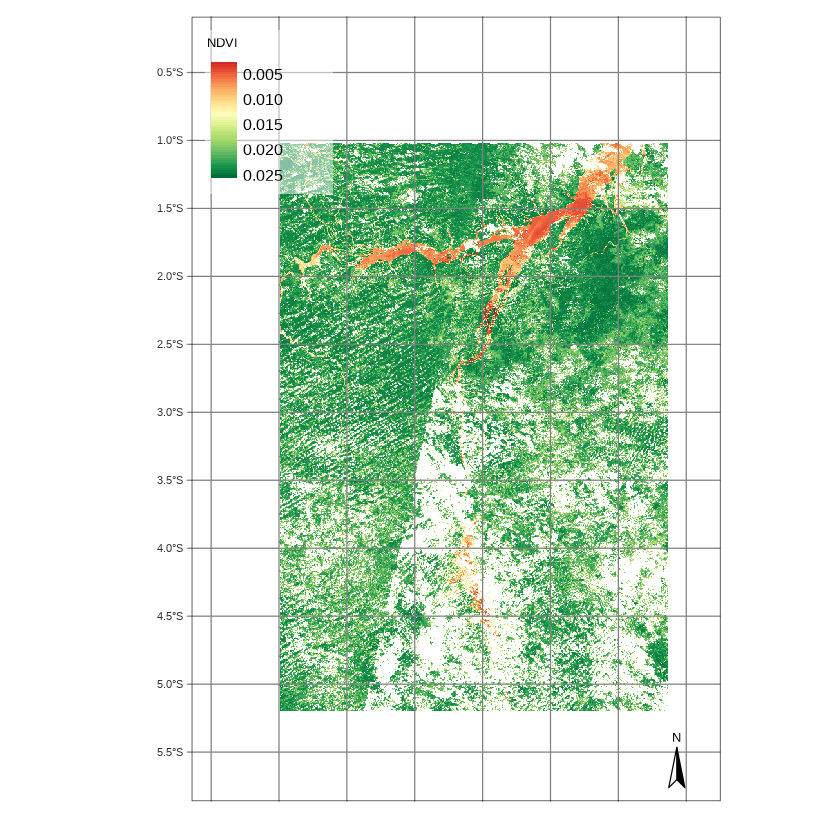

In [15]:
st <- Sys.time()
mosaic_cube <- sits_mosaic(
  cube = s2_regular_cube,
  roi = bbox,
  crs = "EPSG:4326",
  output_dir = MOSAIC_IMAGES_FOLDER,
  progress = TRUE,
  multicores = MULTICORES
)
proc_time_s <- difftime(Sys.time(), st, units = "secs")
print(paste0("Execution time: ", proc_time_s, " seconds"))

plot(mosaic_cube, band = "NDVI", time = 1)

### 1.7 For each computed mosaic, extract mean for each municipality

In [16]:
mosaic_filepaths <- list.files(MOSAIC_IMAGES_FOLDER, full.names = TRUE)
mosaic_filepaths

[1] "mosaic_by_month/SENTINEL-2_MSI_MOSAIC_2019-01-01_2019-01-01_NDVI_v1.tif"
 [2] "mosaic_by_month/SENTINEL-2_MSI_MOSAIC_2019-02-01_2019-02-01_NDVI_v1.tif"
 [3] "mosaic_by_month/SENTINEL-2_MSI_MOSAIC_2019-03-01_2019-03-01_NDVI_v1.tif"
 [4] "mosaic_by_month/SENTINEL-2_MSI_MOSAIC_2019-04-01_2019-04-01_NDVI_v1.tif"
 [5] "mosaic_by_month/SENTINEL-2_MSI_MOSAIC_2019-05-01_2019-05-01_NDVI_v1.tif"
 [6] "mosaic_by_month/SENTINEL-2_MSI_MOSAIC_2019-06-01_2019-06-01_NDVI_v1.tif"
 [7] "mosaic_by_month/SENTINEL-2_MSI_MOSAIC_2019-07-01_2019-07-01_NDVI_v1.tif"
 [8] "mosaic_by_month/SENTINEL-2_MSI_MOSAIC_2019-08-01_2019-08-01_NDVI_v1.tif"
 [9] "mosaic_by_month/SENTINEL-2_MSI_MOSAIC_2019-09-01_2019-09-01_NDVI_v1.tif"
[10] "mosaic_by_month/SENTINEL-2_MSI_MOSAIC_2019-10-01_2019-10-01_NDVI_v1.tif"
[11] "mosaic_by_month/SENTINEL-2_MSI_MOSAIC_2019-11-01_2019-11-01_NDVI_v1.tif"
[12] "mosaic_by_month/SENTINEL-2_MSI_MOSAIC_2019-12-01_2019-12-01_NDVI_v1.tif"
[13] "mosaic_by_month/SENTINEL-2_MSI_MOSAIC_2020-01-01_2020-01-01_NDVI_v1.tif"
[14] "mosaic_by_month/SENTINEL-2_MSI_MOSAIC_2020-02-01_2020-02-01_NDVI_v1.tif"
[15] "mosaic_by_month/SENTINEL-2_MSI_MOSAIC_2020-03-01_2020-03-01_NDVI_v1.tif"
[16] "mosaic_by_month/SENTINEL-2_MSI_MOSAIC_2020-04-01_2020-04-01_NDVI_v1.tif"
[17] "mosaic_by_month/SENTINEL-2_MSI_MOSAIC_2020-05-01_2020-05-01_NDVI_v1.tif"
[18] "mosaic_by_month/SENTINEL-2_MSI_MOSAIC_2020-06-01_2020-06-01_NDVI_v1.tif"
[19] "mosaic_by_month/SENTINEL-2_MSI_MOSAIC_2020-07-01_2020-07-01_NDVI_v1.tif"
[20] "mosaic_by_month/SENTINEL-2_MSI_MOSAIC_2020-08-01_2020-08-01_NDVI_v1.tif"
[21] "mosaic_by_month/SENTINEL-2_MSI_MOSAIC_2020-09-01_2020-09-01_NDVI_v1.tif"
[22] "mosaic_by_month/SENTINEL-2_MSI_MOSAIC_2020-10-01_2020-10-01_NDVI_v1.tif"
[23] "mosaic_by_month/SENTINEL-2_MSI_MOSAIC_2020-11-01_2020-11-01_NDVI_v1.tif"
[24] "mosaic_by_month/SENTINEL-2_MSI_MOSAIC_2020-12-01_2020-12-01_NDVI_v1.tif"
[25] "mosaic_by_month/SENTINEL-2_MSI_MOSAIC_2021-01-01_2021-01-01_NDVI_v1.tif"
[26] "mosaic_by_month/SENTINEL-2_MSI_MOSAIC_2021-02-01_2021-02-01_NDVI_v1.tif"
[27] "mosaic_by_month/SENTINEL-2_MSI_MOSAIC_2021-03-01_2021-03-01_NDVI_v1.tif"
[28] "mosaic_by_month/SENTINEL-2_MSI_MOSAIC_2021-04-01_2021-04-01_NDVI_v1.tif"
[29] "mosaic_by_month/SENTINEL-2_MSI_MOSAIC_2021-05-01_2021-05-01_NDVI_v1.tif"
[30] "mosaic_by_month/SENTINEL-2_MSI_MOSAIC_2021-06-01_2021-06-01_NDVI_v1.tif"
[31] "mosaic_by_month/SENTINEL-2_MSI_MOSAIC_2021-07-01_2021-07-01_NDVI_v1.tif"
[32] "mosaic_by_month/SENTINEL-2_MSI_MOSAIC_2021-08-01_2021-08-01_NDVI_v1.tif"
[33] "mosaic_by_month/SENTINEL-2_MSI_MOSAIC_2021-09-01_2021-09-01_NDVI_v1.tif"
[34] "mosaic_by_month/SENTINEL-2_MSI_MOSAIC_2021-10-01_2021-10-01_NDVI_v1.tif"
[35] "mosaic_by_month/SENTINEL-2_MSI_MOSAIC_2021-11-01_2021-11-01_NDVI_v1.tif"
[36] "mosaic_by_month/SENTINEL-2_MSI_MOSAIC_2021-12-01_2021-12-01_NDVI_v1.tif"

In [27]:
extract_ndvi_to_csv <- function(tif_filepath) {
  st <- Sys.time()

  # Open raster
  r <- raster::raster(tif_filepath)

  # Extract value based on shapefile
  extracted_values <- raster::extract(r, shape_sf, fun = mean, df = TRUE, na.rm = TRUE)

  # TODO: Some rasters will not intersect with shape if raster is not the mosaic

  # Write csv of extracted data. To do this, get image id and append ".csv"
  tif_id <- gsub("\\.tif$", "", basename(tif_filepath))
  csv_output_filepath <- file.path(MOSAIC_CSVS_IMAGES_FOLDER, paste0(tif_id, ".csv"))
  write.csv(extracted_values, csv_output_filepath, row.names = FALSE)

  # Print processing time
  proc_time_s <- difftime(Sys.time(), st, units = "secs")
  print(paste("It took ", proc_time_s, " seconds to extract and generate", csv_output_filepath))
}

lapply(mosaic_filepaths, extract_ndvi_to_csv) 
# extract_ndvi_to_csv("mosaic_by_month/SENTINEL-2_MSI_MOSAIC_2019-01-01_2019-01-01_NDVI_v1.tif")

[1] "It took  44.6751754283905  seconds to extract and generate mosaic_by_month_csvs/SENTINEL-2_MSI_MOSAIC_2019-01-01_2019-01-01_NDVI_v1.csv"
[1] "It took  43.8175964355469  seconds to extract and generate mosaic_by_month_csvs/SENTINEL-2_MSI_MOSAIC_2019-02-01_2019-02-01_NDVI_v1.csv"
[1] "It took  43.8638508319855  seconds to extract and generate mosaic_by_month_csvs/SENTINEL-2_MSI_MOSAIC_2019-03-01_2019-03-01_NDVI_v1.csv"
[1] "It took  269.192006349564  seconds to extract and generate mosaic_by_month_csvs/SENTINEL-2_MSI_MOSAIC_2019-04-01_2019-04-01_NDVI_v1.csv"
[1] "It took  215.863662481308  seconds to extract and generate mosaic_by_month_csvs/SENTINEL-2_MSI_MOSAIC_2019-05-01_2019-05-01_NDVI_v1.csv"
[1] "It took  211.894786119461  seconds to extract and generate mosaic_by_month_csvs/SENTINEL-2_MSI_MOSAIC_2019-06-01_2019-06-01_NDVI_v1.csv"
[1] "It took  199.710391283035  seconds to extract and generate mosaic_by_month_csvs/SENTINEL-2_MSI_MOSAIC_2019-07-01_2019-07-01_NDVI_v1.csv"
[1] "I

[[1]]
[1] "It took  44.6751754283905  seconds to extract and generate mosaic_by_month_csvs/SENTINEL-2_MSI_MOSAIC_2019-01-01_2019-01-01_NDVI_v1.csv"

[[2]]
[1] "It took  43.8175964355469  seconds to extract and generate mosaic_by_month_csvs/SENTINEL-2_MSI_MOSAIC_2019-02-01_2019-02-01_NDVI_v1.csv"

[[3]]
[1] "It took  43.8638508319855  seconds to extract and generate mosaic_by_month_csvs/SENTINEL-2_MSI_MOSAIC_2019-03-01_2019-03-01_NDVI_v1.csv"

[[4]]
[1] "It took  269.192006349564  seconds to extract and generate mosaic_by_month_csvs/SENTINEL-2_MSI_MOSAIC_2019-04-01_2019-04-01_NDVI_v1.csv"

[[5]]
[1] "It took  215.863662481308  seconds to extract and generate mosaic_by_month_csvs/SENTINEL-2_MSI_MOSAIC_2019-05-01_2019-05-01_NDVI_v1.csv"

[[6]]
[1] "It took  211.894786119461  seconds to extract and generate mosaic_by_month_csvs/SENTINEL-2_MSI_MOSAIC_2019-06-01_2019-06-01_NDVI_v1.csv"

[[7]]
[1] "It took  199.710391283035  seconds to extract and generate mosaic_by_month_csvs/SENTINEL-2_MSI_MOSAIC_2019-07-01_2019-07-01_NDVI_v1.csv"

[[8]]
[1] "It took  202.354318857193  seconds to extract and generate mosaic_by_month_csvs/SENTINEL-2_MSI_MOSAIC_2019-08-01_2019-08-01_NDVI_v1.csv"

[[9]]
[1] "It took  207.558956623077  seconds to extract and generate mosaic_by_month_csvs/SENTINEL-2_MSI_MOSAIC_2019-09-01_2019-09-01_NDVI_v1.csv"

[[10]]
[1] "It took  206.826120615005  seconds to extract and generate mosaic_by_month_csvs/SENTINEL-2_MSI_MOSAIC_2019-10-01_2019-10-01_NDVI_v1.csv"

[[11]]
[1] "It took  204.205665588379  seconds to extract and generate mosaic_by_month_csvs/SENTINEL-2_MSI_MOSAIC_2019-11-01_2019-11-01_NDVI_v1.csv"

[[12]]
[1] "It took  203.399286031723  seconds to extract and generate mosaic_by_month_csvs/SENTINEL-2_MSI_MOSAIC_2019-12-01_2019-12-01_NDVI_v1.csv"

[[13]]
[1] "It took  202.009108781815  seconds to extract and generate mosaic_by_month_csvs/SENTINEL-2_MSI_MOSAIC_2020-01-01_2020-01-01_NDVI_v1.csv"

[[14]]
[1] "It took  204.001042604446  seconds to extract and generate mosaic_by_month_csvs/SENTINEL-2_MSI_MOSAIC_2020-02-01_2020-02-01_NDVI_v1.csv"

[[15]]
[1] "It took  207.27379655838  seconds to extract and generate mosaic_by_month_csvs/SENTINEL-2_MSI_MOSAIC_2020-03-01_2020-03-01_NDVI_v1.csv"

[[16]]
[1] "It took  202.511696338654  seconds to extract and generate mosaic_by_month_csvs/SENTINEL-2_MSI_MOSAIC_2020-04-01_2020-04-01_NDVI_v1.csv"

[[17]]
[1] "It took  202.519921302795  seconds to extract and generate mosaic_by_month_csvs/SENTINEL-2_MSI_MOSAIC_2020-05-01_2020-05-01_NDVI_v1.csv"

[[18]]
[1] "It took  39.336457490921  seconds to extract and generate mosaic_by_month_csvs/SENTINEL-2_MSI_MOSAIC_2020-06-01_2020-06-01_NDVI_v1.csv"

[[19]]
[1] "It took  39.7198891639709  seconds to extract and generate mosaic_by_month_csvs/SENTINEL-2_MSI_MOSAIC_2020-07-01_2020-07-01_NDVI_v1.csv"

[[20]]
[1] "It took  39.3007581233978  seconds to extract and generate mosaic_by_month_csvs/SENTINEL-2_MSI_MOSAIC_2020-08-01_2020-08-01_NDVI_v1.csv"

[[21]]
[1] "It took  40.2714848518372  seconds to extract and generate mosaic_by_month_csvs/SENTINEL-2_MSI_MOSAIC_2020-09-01_2020-09-01_NDVI_v1.csv"

[[22]]
[1] "It took  39.7700855731964  seconds to extract and generate mosaic_by_month_csvs/SENTINEL-2_MSI_MOSAIC_2020-10-01_2020-10-01_NDVI_v1.csv"

[[23]]
[1] "It took  40.3085136413574  seconds to extract and generate mosaic_by_month_csvs/SENTINEL-2_MSI_MOSAIC_2020-11-01_2020-11-01_NDVI_v1.csv"

[[24]]
[1] "It took  39.7539498806  seconds to extract and generate mosaic_by_month_csvs/SENTINEL-2_MSI_MOSAIC_2020-12-01_2020-12-01_NDVI_v1.csv"

[[25]]
[1] "It took  43.9688012599945  seconds to extract and generate mosaic_by_month_csvs/SENTINEL-2_MSI_MOSAIC_2021-01-01_2021-01-01_NDVI_v1.csv"

[[26]]
[1] "It took  42.0802824497223  seconds to extract and generate mosaic_by_month_csvs/SENTINEL-2_MSI_MOSAIC_2021-02-01_2021-02-01_NDVI_v1.csv"

[[27]]
[1] "It took  42.6485188007355  seconds to extract and generate mosaic_by_month_csvs/SENTINEL-2_MSI_MOSAIC_

### Open all monthly csvs and merge

In [28]:
mosaic_csvs_filepaths <- list.files(MOSAIC_CSVS_IMAGES_FOLDER, full.names = TRUE)
mosaic_csvs_filepaths

[1] "mosaic_by_month_csvs/SENTINEL-2_MSI_MOSAIC_2019-01-01_2019-01-01_NDVI_v1.csv"
 [2] "mosaic_by_month_csvs/SENTINEL-2_MSI_MOSAIC_2019-02-01_2019-02-01_NDVI_v1.csv"
 [3] "mosaic_by_month_csvs/SENTINEL-2_MSI_MOSAIC_2019-03-01_2019-03-01_NDVI_v1.csv"
 [4] "mosaic_by_month_csvs/SENTINEL-2_MSI_MOSAIC_2019-04-01_2019-04-01_NDVI_v1.csv"
 [5] "mosaic_by_month_csvs/SENTINEL-2_MSI_MOSAIC_2019-05-01_2019-05-01_NDVI_v1.csv"
 [6] "mosaic_by_month_csvs/SENTINEL-2_MSI_MOSAIC_2019-06-01_2019-06-01_NDVI_v1.csv"
 [7] "mosaic_by_month_csvs/SENTINEL-2_MSI_MOSAIC_2019-07-01_2019-07-01_NDVI_v1.csv"
 [8] "mosaic_by_month_csvs/SENTINEL-2_MSI_MOSAIC_2019-08-01_2019-08-01_NDVI_v1.csv"
 [9] "mosaic_by_month_csvs/SENTINEL-2_MSI_MOSAIC_2019-09-01_2019-09-01_NDVI_v1.csv"
[10] "mosaic_by_month_csvs/SENTINEL-2_MSI_MOSAIC_2019-10-01_2019-10-01_NDVI_v1.csv"
[11] "mosaic_by_month_csvs/SENTINEL-2_MSI_MOSAIC_2019-11-01_2019-11-01_NDVI_v1.csv"
[12] "mosaic_by_month_csvs/SENTINEL-2_MSI_MOSAIC_2019-12-01_2019-12-01_NDVI_v1.csv"
[13] "mosaic_by_month_csvs/SENTINEL-2_MSI_MOSAIC_2020-01-01_2020-01-01_NDVI_v1.csv"
[14] "mosaic_by_month_csvs/SENTINEL-2_MSI_MOSAIC_2020-02-01_2020-02-01_NDVI_v1.csv"
[15] "mosaic_by_month_csvs/SENTINEL-2_MSI_MOSAIC_2020-03-01_2020-03-01_NDVI_v1.csv"
[16] "mosaic_by_month_csvs/SENTINEL-2_MSI_MOSAIC_2020-04-01_2020-04-01_NDVI_v1.csv"
[17] "mosaic_by_month_csvs/SENTINEL-2_MSI_MOSAIC_2020-05-01_2020-05-01_NDVI_v1.csv"
[18] "mosaic_by_month_csvs/SENTINEL-2_MSI_MOSAIC_2020-06-01_2020-06-01_NDVI_v1.csv"
[19] "mosaic_by_month_csvs/SENTINEL-2_MSI_MOSAIC_2020-07-01_2020-07-01_NDVI_v1.csv"
[20] "mosaic_by_month_csvs/SENTINEL-2_MSI_MOSAIC_2020-08-01_2020-08-01_NDVI_v1.csv"
[21] "mosaic_by_month_csvs/SENTINEL-2_MSI_MOSAIC_2020-09-01_2020-09-01_NDVI_v1.csv"
[22] "mosaic_by_month_csvs/SENTINEL-2_MSI_MOSAIC_2020-10-01_2020-10-01_NDVI_v1.csv"
[23] "mosaic_by_month_csvs/SENTINEL-2_MSI_MOSAIC_2020-11-01_2020-11-01_NDVI_v1.csv"
[24] "mosaic_by_month_csvs/SENTINEL-2_MSI_MOSAIC_2020-12-01_2020-12-01_NDVI_v1.csv"
[25] "mosaic_by_month_csvs/SENTINEL-2_MSI_MOSAIC_2021-01-01_2021-01-01_NDVI_v1.csv"
[26] "mosaic_by_month_csvs/SENTINEL-2_MSI_MOSAIC_2021-02-01_2021-02-01_NDVI_v1.csv"
[27] "mosaic_by_month_csvs/SENTINEL-2_MSI_MOSAIC_2021-03-01_2021-03-01_NDVI_v1.csv"
[28] "mosaic_by_month_csvs/SENTINEL-2_MSI_MOSAIC_2021-04-01_2021-04-01_NDVI_v1.csv"
[29] "mosaic_by_month_csvs/SENTINEL-2_MSI_MOSAIC_2021-05-01_2021-05-01_NDVI_v1.csv"
[30] "mosaic_by_month_csvs/SENTINEL-2_MSI_MOSAIC_2021-06-01_2021-06-01_NDVI_v1.csv"
[31] "mosaic_by_month_csvs/SENTINEL-2_MSI_MOSAIC_2021-07-01_2021-07-01_NDVI_v1.csv"
[32] "mosaic_by_month_csvs/SENTINEL-2_MSI_MOSAIC_2021-08-01_2021-08-01_NDVI_v1.csv"
[33] "mosaic_by_month_csvs/SENTINEL-2_MSI_MOSAIC_2021-09-01_2021-09-01_NDVI_v1.csv"
[34] "mosaic_by_month_csvs/SENTINEL-2_MSI_MOSAIC_2021-10-01_2021-10-01_NDVI_v1.csv"
[35] "mosaic_by_month_csvs/SENTINEL-2_MSI_MOSAIC_2021-11-01_2021-11-01_NDVI_v1.csv"
[36] "mosaic_by_month_csvs/SENTINEL-2_MSI_MOSAIC_2021-12-01_2021-12-01_NDVI_v1.csv"

In [29]:
pixels_ndvi_to_feature_mean <- function(csv_filepath){
  st <- Sys.time()

  csv_filename <- basename(csv_filepath)
  
  pixels_ndvi <- read.csv(csv_filepath)

  shape_with_id <- shape_df %>%
    select(CD_MUN) %>%
    mutate(ID = as.integer(rownames(shape_df)))

  merge_mean_with_shape <- merge(pixels_ndvi, shape_with_id, by = "ID") %>%
    rename(cd_mun = CD_MUN, ndvi = NDVI) %>%
    # ????????????????????????????????????????????????????????????
    mutate(year_month = str_extract(csv_filename, "\\d{4}-\\d{2}")) %>%
    # ????????????????????????????????????????????????????????????
    mutate(ndvi = ndvi * 0.0001) %>%
    select(cd_mun, year_month, ndvi)

  proc_time_s <- difftime(Sys.time(), st, units = "secs")
  print(paste0("Execution time: ", proc_time_s, " seconds"))

  return(merge_mean_with_shape)
}

# Read each mean NDVI csv, merge with original shapefile and set year_month
list_ndvi_means <- lapply(mosaic_csvs_filepaths, pixels_ndvi_to_feature_mean)
# Bind all dataframes in one big
df_ndvi_means <- do.call(rbind, list_ndvi_means)

dim(df_ndvi_means)
head(df_ndvi_means, 30)

[1] "Execution time: 0.0238888263702393 seconds"
[1] "Execution time: 0.0182271003723145 seconds"
[1] "Execution time: 0.0185632705688477 seconds"
[1] "Execution time: 0.0188314914703369 seconds"
[1] "Execution time: 0.020925760269165 seconds"
[1] "Execution time: 0.0240592956542969 seconds"
[1] "Execution time: 0.0201146602630615 seconds"
[1] "Execution time: 0.0224020481109619 seconds"
[1] "Execution time: 0.0233860015869141 seconds"
[1] "Execution time: 0.0180830955505371 seconds"
[1] "Execution time: 0.0179193019866943 seconds"
[1] "Execution time: 0.0173211097717285 seconds"
[1] "Execution time: 0.017690896987915 seconds"
[1] "Execution time: 0.018186092376709 seconds"
[1] "Execution time: 0.0179798603057861 seconds"
[1] "Execution time: 0.0176286697387695 seconds"
[1] "Execution time: 0.017869234085083 seconds"
[1] "Execution time: 0.0176563262939453 seconds"
[1] "Execution time: 0.0176687240600586 seconds"
[1] "Execution time: 0.0179193019866943 seconds"
[1] "Execution time: 0.0

[1] 756   3

,CD_MUN,year_month,mean_NDVI
,<chr>,<chr>,<dbl>
1,1500107,2019-01,0.01830809
2,1500800,2019-01,0.01879105
3,1501105,2019-01,0.02110660
4,1501204,2019-01,0.02033529
5,1501303,2019-01,0.01650262
6,1501402,2019-01,0.01403199
7,1501501,2019-01,0.02026479
8,1501782,2019-01,0.02007037
9,1502103,2019-01,0.01913963


### Save NDVI data

In [31]:
FINAL_CSV_NAME <- "csvs/data_ndvi_months_2019.csv"

write.csv(df_ndvi_means, FINAL_CSV_NAME, row.names = FALSE)